# Explore data augmentations

This notebook will be used to test different data augmentation strategies. In your config file, you can modify the augmentations by adding `data_augmentation_options`. For example, I would like to add a random RGB to gray transform with a probability of 0.2:
```
data_augmentation_options {
    random_rgb_to_gray {
    probability: 0.2
    }
```

A complete list of augmentation is provided the [`preprocessor.proto` file of the Tf Object Detection API](https://github.com/tensorflow/models/blob/master/research/object_detection/protos/preprocessor.proto).

### Helper functions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
import tensorflow as tf

In [2]:
def recenter_image(image):
    # ssd preprocessing
    image += [123.68, 116.779, 103.939]
    return image

def display_instances(image, bboxes, classes):
    image = recenter_image(image)
    w, h, _ = image.shape
    # resize the bboxes
    bboxes[:, [0, 2]] *= w
    bboxes[:, [1, 3]] *= h
    
    f, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image.astype(np.uint8))
    for bb, cl in zip(bboxes, classes):
        y1, x1, y2, x2 = bb
        rec = Rectangle((x1, y1), x2-x1, y2-y1, facecolor='none', edgecolor='r', linewidth=2)
        ax.add_patch(rec)
    plt.show()

def display_batch(batch):
    # get images, bboxes and classes
    batched_images = batch[0]['image'].numpy()
    batched_bboxes = batch[1]['groundtruth_boxes'].numpy()
    batched_classes = batch[1]['groundtruth_classes'].numpy()
    num_bboxes = batch[1]['num_groundtruth_boxes'].numpy()
    batch_size = batched_images.shape[0]
    for idx in range(batch_size):
        display_instances(batched_images[idx, ...], 
                          batched_bboxes[idx, :num_bboxes[idx], :],
                          batched_classes[idx, ...])

### Display augmentations

In [3]:
from project.utils import get_train_input
from object_detection.core import preprocessor

import logging
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

In [4]:
train_dataset = get_train_input("project/training/reference/pipeline_new.config")

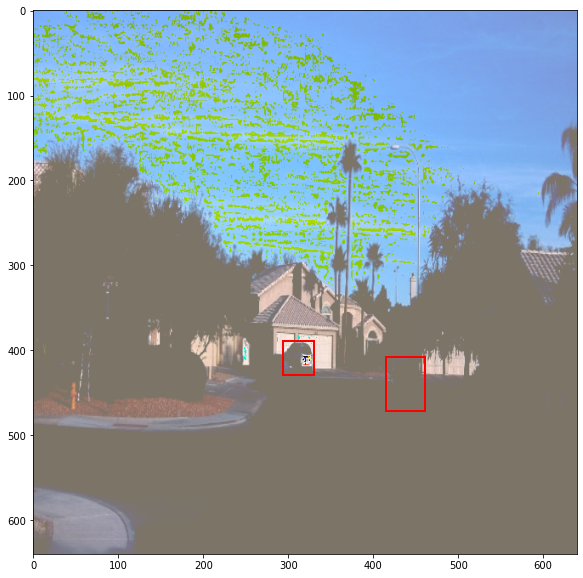

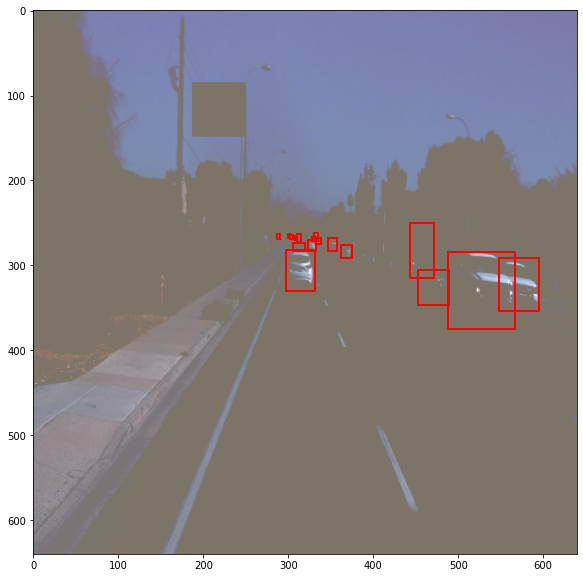

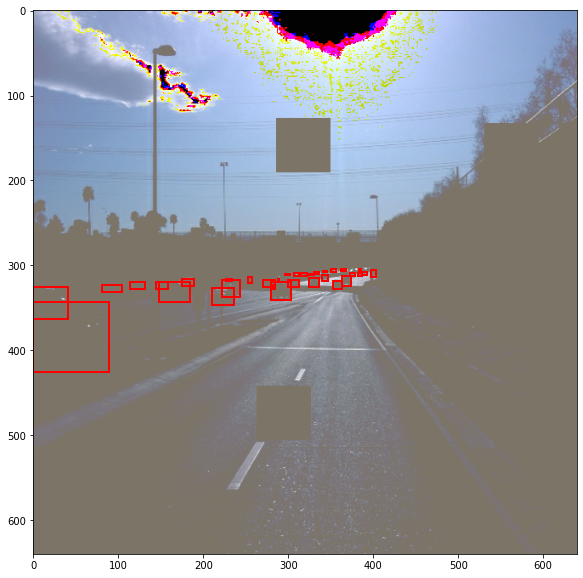

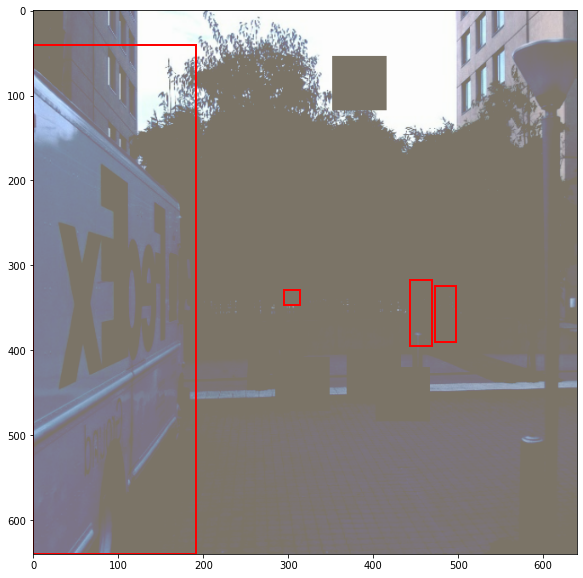

In [49]:
%matplotlib inline

for batch in train_dataset.take(1):
    img = batch[0]['image']
    bboxes = batch[1]['groundtruth_boxes']
    labels = batch[1]['groundtruth_classes'].numpy()
    num_bboxes = batch[1]['num_groundtruth_boxes'].numpy()
    probability = 1

    # resize to target size
    img = preprocessor.resize_image(img, new_height=640, new_width=640)[0]

    # apply transformations
    img, bboxes = preprocessor.random_horizontal_flip(img, bboxes, probability=probability)
    # img = tf.stack([preprocessor.random_adjust_contrast(x, max_delta=0.002) for x in img])
    img = tf.stack([preprocessor.random_adjust_brightness(x, max_delta=0.02) for x in img])
    # img = tf.stack([preprocessor.random_patch_gaussian(x) for x in img])
    img = tf.stack([preprocessor.random_black_patches(x, probability=0.25) for x in img])
    # img = tf.stack([preprocessor.random_pixel_value_scale(x) for x in img])
    # bboxes = tf.stack([preprocessor.random_jitter_boxes(x) for x in bboxes])
    # img = tf.stack([preprocessor.random_rgb_to_gray(x, probability=probability) for x in img])

    batch[0]['image'] = img
    batch[1]['groundtruth_boxes'] = bboxes

    display_batch(batch)